# Introduction to Footprints
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64))
<br>Last Verified to Run: **2018-12-10**
<br>Verified Stack Release: **16.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Understand Footprints, and their relationship to detection, and measurement
2. Use methods and attributes from the footprint class to get information like centroids, size, shape, of the footprint
3. Perform operations on footprints, like dilation an errosion
4. Understand the relaitonship between peaks and footprints, and their role in deblending
4. Use footprints to access pixel level data in their parent exposures

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd .. && python setup.py -q develop --user && cd -

/home/ishasan/lsst/StackClub/SourceDetection


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-ishasan-r160
lsst_distrib          16.0+1     	current v16_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline

import warnings
# Filter some warnings printed by v16.0 of the stack
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay

In [5]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.rcParams['figure.figsize'] = (8.0, 8.0)

### Useful resources:

- [Documentation on footprints](https://github.com/lsst/afw/blob/b4f0cd2fac5183cac01ac5e8ac92be759afed8a3/doc/lsst.afw.detection/Footprint.rst) from the pipelines documentation in the afw package, courtesy Jonathan Sick: 
- Footprint [Doxygen page](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1detection_1_1_footprint.html)
- Jim Bosch's [HSC Software Pipeline paper](https://arxiv.org/pdf/1705.06766.pdf), particularly Section 4.8
- [Low Surface Brightness Stack Club Notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb) by Alex Drlica-Wagner

# Footprints

To paraphrase from Bosch et al 2017, 

> Footprints ... record the exact above-threshold detection region. These are similar to a per-source version of SExtractor’s “segmentation map"

As you might expect, this means Footprints are integral to high level ccd processing tasks-like detection, measurement, and deblending-which directly impact science results. Because footprints are so closely related to these very important processes, we will take a close look at them in this notebook.

## The basics: Footprint geometry and location
In the quote above, an analogy was drawn between Footprints and segmentation maps, as they both identify above threshold pixels. As we first introduce Footprints, we will concentrate on similarity as it gives us a place to start understanding the location and gemoteric properties of Footprints. 

In [6]:
# grab some data
# The dafPersist was trying to set the matplotlib backend, catch warning
datadir = "/project/shared/data/Twinkles_subset/output_data_v2"
butler = dafPersist.Butler(datadir)
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
calexp = butler.get('calexp', **dataId)

In [7]:
# set up minimal detection task
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10       # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue

sourceDetectionTask =   SourceDetectionTask(config=config)

Because we are just interested in interacting with footprints, we will use the `detectFootprints` method in sourceDetectionTask instead of the run method. `detectFootprints` will return a struct to us that deals with footPrints. If we used the run method, we would recieve a struct that included footprints along with a source table, which we do not need for our discussion here. If you are truely curious about the run method, you can see it in action in Alex Drlica-Wagner's LowSurfaceBrightness notebook, referenced above

In [8]:
# run detection on our frame
detect_res = sourceDetectionTask.detectFootprints(calexp)

`detect_res` is a struct. Struct objects are simmilar to python dictionaries, in that they have key value pairs. However, here you access the values by using the keys as an attribute. If you are and IDL user, these will remind you of Structures in IDL

In [9]:
detect_res

Struct(positive=<lsst.afw.detection._footprintSet.FootprintSet object at 0x7f13081da0d8>; negative=None; factor=1.0; background=<lsst.afw.math.backgroundList.BackgroundList object at 0x7f13081dacc0>; numPos=1060; numPosPeaks=1158; numNeg=1; numNegPeaks=1)

Looking at `detect_res`, we can see that there are attributes associated with sources detected positive-that is above threshold, and detected negative. Let us concentrate on the positive detections for now. The positive attribute holds a `FootprintSet`, an object that contains all the positively detected footprints. The `numPos` attribute tells us we have 1060 footprints that were detected positive. The `numPosPeaks` attribute tells us 1158 peaks were detected positive. This is because more than one peak can belong to a footprint. We will discuss peaks more fully in a later section, but for now you may regard them as what they sound like-the 'sharp' points in the surface brightness profile.

In [10]:
# lets grab the above threshold footprints that were detected and assign them to a varriable
fpset = detect_res.positive

the variable fpset is a FootprintSet object. While it contains many footprints itself, it does not offer an super easy way to interact with the individual footprints. However, we can ask the FootprintSet to give us a list of footprints, which we can iterate over

In [11]:
fps = fpset.getFootprints()

Now we have drilled our way down to getting our hands on footprints. Lets discuss some of their methods and attributes. To begin, we will concentrate on Footprint geometry and location.

In [12]:
# Get the region-the pixel coordinates that describes the chip this footprint belongs too
fps[0].getRegion()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4000, 4072))

In [13]:
# The center of the footprint, in detector coordinates
fps[0].getCentroid()

Point2D(1979.951515, 8.206060606)

In [14]:
# The bounding box of the footprint.
# Not all of the pixels in the bounding box are pixels in the footprint
fps[0].getBBox()

Box2I(minimum=Point2I(1972, 2), dimensions=Extent2I(17, 14))

In [15]:
# Area of the footprint. NOTE this is not the area of the bounding box.
# It is the number of pixels associated with the footprint
fps[0].getArea()

165

The shape of a footprint can be calculated. It is assumed to be an ellipse, and the relevent parameters are defined with the quadurpole, $Q_{i,j}$, a matrix containing the second moments, where

$$Q_{i,j} = \int x_i x_j \mathrm{d}x^i \mathrm{d}x^j$$

Notice this definition *does not* include the surface brightness of the detected object. That is to say, the quadropole computed for footprints describes the geometry of the pixels in the footprint, *not* the intensity weighted shape of its detected object.

The elements for a footprint can be computed with the getShape() method. Note that the matix is symmetric.

In [16]:
fps[0].getShape()

Quadrupole(ixx=15.088558310376527, iyy=11.70299357208448, ixy=-0.03849403122130394)

Looking at $Q_{i,j}$, the diagonal elements are close in magnitude, and the off diagonal elements are close to zero. We expect the footprint to be roughly circular. Now that we have all the pertinent information about where the footprint is and what pixels belong to it, we can display it and see if our expectation is true.

## Visualizing Footprints & HeavyFootprints

We get information about which pixels in the footprints bounding box actually belong to the footprint by using its Span. The span will give us _n_ rows, with _m_ elements, where _n_ and _m_ are the Height and Width of the bounding box, respectively. If an element in the span is zero, this means the pixel is inside the footprint's bounding box but does not belong to the footprint. If an element is one, the pixel is both in the bounding box and associated with the footprint.

In [17]:
fps[0].getSpans()

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

The output returned in the above cell is a _span set_. To quote the [doxygen for Spans](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1geom_1_1_span_set.html) 

>A SpanSet is a collection of Span classes. As each Span encodes a range of pixels on a given row, a SpanSet represents an arbitrary collection of pixels on an image. The SpanSet class also contains mathematical set style operators, for working with the collection of pixels, and helper functions which make use of the area defined to perform localized actions

To disect the quote above, we can think of span sets as proper sets, in the mathematical sense. They support opperations like intersection and union.

If we wanted to now extract the actual pixel values that correspond to the ones in the span, we need to do a little more leg work. At the moment, our Footprints have no way of accessing pixel values on the calexp. To remedy this, we will turn our Footprint into a `HeavyFootprint`. HeavyFootprints have all of the qualities of Footprints, but additionally 'know' about pixel level data from their calexp's image, variance, and mask planes.

In [18]:
# first we domonstrate the footprint is not heavy
fps[0].isHeavy()

False

In [19]:
# we will make all the footprins heavy at the same time by operating on the footprint set
fpset.makeHeavy(calexp.getMaskedImage())
# we have to redefine fps
fps = fpset.getFootprints()

In [20]:
# prove the footprints are now indeed heavy
fps[0].isHeavy()

True

In [21]:
# all of the arrays here will be flattend 1D arrays of pixels from the footprint
fps[0].getImageArray()

array([-9.84372520e+00,  8.15535069e+00,  1.51543646e+01, -2.48465633e+01,
       -2.38474941e+01,  1.81515770e+01, -1.84929299e+00,  4.71567116e+01,
        7.01557922e+01,  1.91548634e+01,  4.21539383e+01, -1.18469896e+01,
        3.21520805e+01,  3.21511536e+01,  3.21502190e+01,  3.51492882e+01,
       -1.48427954e+01,  4.15628195e+00, -1.98447018e+01, -1.58456259e+01,
        6.21534500e+01,  4.11525192e+01,  4.41515923e+01,  7.11506653e+01,
       -3.85026836e+00,  9.14879990e+00, -3.08520737e+01, -3.08423080e+01,
        3.41567078e+01, -3.18442116e+01,  3.01548653e+01,  5.71539459e+01,
        6.11529541e+01,  7.11520309e+01,  1.07151100e+02,  7.21501694e+01,
       -1.18506994e+01,  5.61483650e+01,  2.01474323e+01, -4.38534393e+01,
        4.15811348e+00,  2.31571960e+01,  1.01562738e+01,  2.01552944e+01,
        3.21543694e+01,  7.01534424e+01,  1.66152512e+02,  1.03151596e+02,
        7.41506653e+01,  1.33149734e+02,  3.41488037e+01,  1.21478720e+01,
        3.81470032e+01,  

Now we can use the span to reassemble the image array into the footprint. The Span has an `unflatten` method that we will use, giving the footprints imageArray as input.

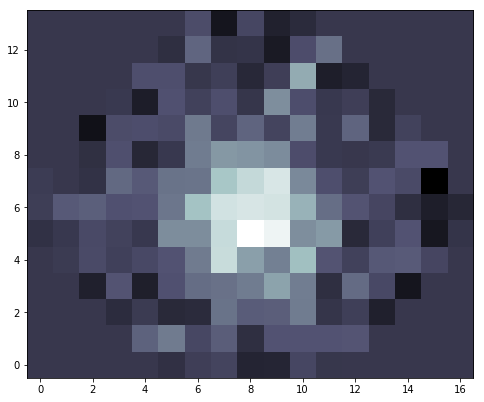

In [22]:
plt.imshow(fps[0].getSpans().unflatten(fps[0].getImageArray()),
           cmap='bone', origin='lower')

We can do a simmilar exercise with the mask plane values, instead of the image plane values. We can first grab the (flattened) mask plane values of the footprint

In [23]:
fps[0].getMaskArray()

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], dtype=int32)

To understand these values, lets look at the mask plane's dictionary

In [24]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7}

The values are the exponent of the bitmask. So Pixels only marked detected will be 2^5 = 32. Pixels that are both on the edge and detected will be 2^5 + 2^4 = 48. Now we will visualize this in a simmilar manner to the afwdisplay exercise we did before, only now we are *only* using data for the footprint because we are using the span.

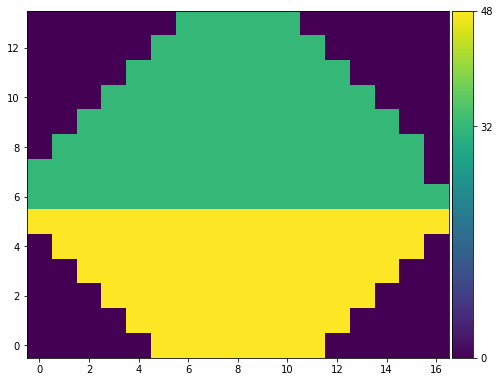

In [25]:
plt.figure(figsize=(8,8))
ax = plt.gca()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
im = plt.imshow(fps[0].getSpans().unflatten(fps[0].getMaskArray()),
                origin='lower')

cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax, ticks=[0, 32, 32+16])

## Erosion and Dilation on Footprints

We can grow or shrink the PSF using the dilate() and erode() methods. You may imagine doing this if you want to ensure you are getting all the flux associated with the detected source. Using these methods requires that we provide a scale by which to grow or shrink the PSF. Typically, this scale is the $\sigma$ of the gaussian PSF scaled by a user defined factor. Let us demonstrate this below

In [26]:
# first get the gaussian fwhm of the PSF 
psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()

# print how many pixels belong to the footprint before we dilate it
print('before dilating the footprint has an area of {}'.format(fps[0].getArea()))

# now we will grow the footprint by 2 x sigma. We need to pass an int
fps[0].dilate(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after dilating the footprint has an area of {}'.format(fps[0].getArea()))

before dilating the footprint has an area of 165
after dilating the footprint has an area of 378


In [27]:
# lets chip away at the footprint by using the erode method now
fps[0].erode(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after eroding the footprint has an area of {}'.format(fps[0].getArea()))

after eroding the footprint has an area of 165


To give us some more intuition on how dilation effects the footprints, we will show cut outs of several footprints before they have been dilated (top row) and after they have been dilated. To exagerate the effect, we will use a large scale length in the dilation.

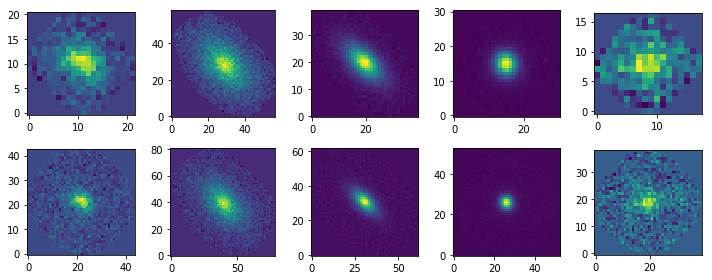

In [28]:
def plot_fp(ax, fp):
    span = fp.getSpans()
    im_data = fp.getImageArray()
    ax.imshow(span.unflatten(im_data), origin='lower')
    return

f, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4))

# prepare a list with indicies of a few footprints
fp_ids = [500,600,700,800,900]

# make cut outs of footprints before dilation
for i, j in zip(range(len(fp_ids)), fp_ids):
    plot_fp(ax[0,i], fps[j])

# dilate footprints
for j in fp_ids:
    fps[j].dilate(int(5*sigma))

# we need to make the dilated footprints heavy again
# updating the spans by dilation does not automatically update their associated image data
fpset.makeHeavy(calexp.getMaskedImage())
fps = fpset.getFootprints()

# cut outs of footprints after dilation
for i, j in zip(range(len(fp_ids)), fp_ids):
    plot_fp(ax[1,i], fps[j])
    
plt.tight_layout()

spans can be disconnected, you can have two regions associated with a span set that are not connected. during processing, you make sure that it is ensured that they are connected. however, by dilating or eroding, you could make them non contiguous. if you had two stars next to each other, then erode them, you might split the footpring into two non connected spans. there are some methods that help you see if its contiguous. 

## Footprints, Peaks and Deblending

In the previous sections, we paid close attention to a fairly bright, isolated source and its associated Footprint that we identified as being above a 10 $\sigma$ threshold. In pratice, especially as we detect with lower thresholds, Footprints from a first past threshold detection can contain several astronomical objects. This is because the wings of the intensity profiles of individual, but closely packed, sources can bleed into each other, forming one above threshold region, and one Footprint. Formally, pixels which are local maxima in the smoothed image during detection are regarded as peaks. A footprint's peaks are assumed to belong to distinct astrophysical sources. The peaks in the Footprints are used as input in subesquent deblending processes, and are assigned to their own deblended children Footprints. To quote Bosch et al 2017

>  Our detection algorithm ... represents a blend as a Footprint containing multiple peaks. The job of our deblender algorithm is to apportion the flux in that Footprint to the peaks, creating a “child” ... for each peak that allows it to be measured as a distinct source.

That is to say, in addition to identifying the location and real estate on the CCD that blended sources occupy, the deblender *also allocates flux in the parent object to its deblended children*. As a result, the flux in a deblended `HeavyFootprint` will not necessarily equal the flux at the same pixels in its image.

In this section we will examine Footprints that contain more than one peak, and the interplay between Footprints, peaks, and deblending. To do so, we will read Footprints from data that has already gone through detection, deblending, and measurement. 

In [29]:
# Lets grab the calexp and source catalog
calexp = butler.get('calexp', **dataId)
cat = butler.get('src', **dataId)

In the following few cells, we will use a few afwTable tricks. Because we are interested in understanding peaks and deblending, we are going to sort the source catalog to find the source with the largest number of deblended children. You can learn more about afwTables in the [afwTables: A Guided Tour](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/afw_table_guided_tour.ipynb) notebook.

In [30]:
# First get the key for the deblend_nChild field, and id. We need these to sort on them
nChild_key = cat.getSchema().find('deblend_nChild').key
idKey = cat.getIdKey()

# Sort the catalog on number of children
cat.sort(nChild_key)
# The catalog is sorted low to high, so grab the last element
# Use the nChild key to get the number of children, and the id key to get the parent's ID
num_children = cat[-1].get(nChild_key)
parent_id = cat[-1].getId()

# Footprints are stored in the source catalog, we can access them easily
parent_fp = cat[-1].getFootprint()
print('Parent source {} has {} deblended children'.format(parent_id, num_children))

Parent source 1010357503601 has 48 deblended children


The Footprint of the parent object contains catalog of the peaks it contains. This catalog gives the peaks and thier locations and peak pixel value in the *smoothed* image. During the detection process, the image in question is smoothed over with a spatial filter. A nice demonstration of this is avaliable in ADW's [LowSurfaceBrightness notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb). The peaks' centers and counts are in this smoothed image, and may differ slightly from their subsequent children footprints after deblending.

In [31]:
parent_fp.getPeaks()

<class 'lsst.afw.detection._peak.PeakCatalog'>
  id    f_x   f_y   i_x i_y  peakValue 
        pix   pix   pix pix      ct    
------ ----- ------ --- ---- ----------
193828 332.0 3310.0 332 3310  433.84677
193822 353.0 3287.0 353 3287 124.218796
193831 308.0 3337.0 308 3337   114.6474
193835 335.0 3360.0 335 3360    94.9135
193824 313.0 3293.0 313 3293  71.020546
193825 373.0 3294.0 373 3294   65.93965
193832 334.0 3350.0 334 3350   64.40326
193816 348.0 3260.0 348 3260  63.373177
193817 356.0 3263.0 356 3263  60.775974
193827 368.0 3309.0 368 3309  60.514282
   ...   ...    ... ...  ...        ...
193720 393.0 3251.0 393 3251  27.420324
193707 389.0 3234.0 389 3234   27.08198
193719 396.0 3248.0 396 3248  27.052425
193830 271.0 3333.0 271 3333  26.808804
193718 406.0 3246.0 406 3246  26.662615
193754 386.0 3314.0 386 3314  26.585815
193710 399.0 3239.0 399 3239  26.502201
193826 288.0 3299.0 288 3299   26.28766
193794 264.0 3362.0 264 3362  26.089592
193730 318.0 3263.0 318 3263  25.

Now we will set up a visualization to see our parent source, the locations of its peaks (as red crosses), and the centers of the deblended children footprints (as orange circles).

In [32]:
# Get the centroid of the parent
parent_x = cat[-1].getX()
parent_y = cat[-1].getY()

parent_x = int(parent_x)
parent_y = int(parent_y)

In [33]:
# Sort the catalog on ID so we can get a view of the 
# catalog that contains the children of the parent source
cat.sort(idKey)
child_cat = cat.getChildren(parent_id)

<Figure size 576x576 with 0 Axes>

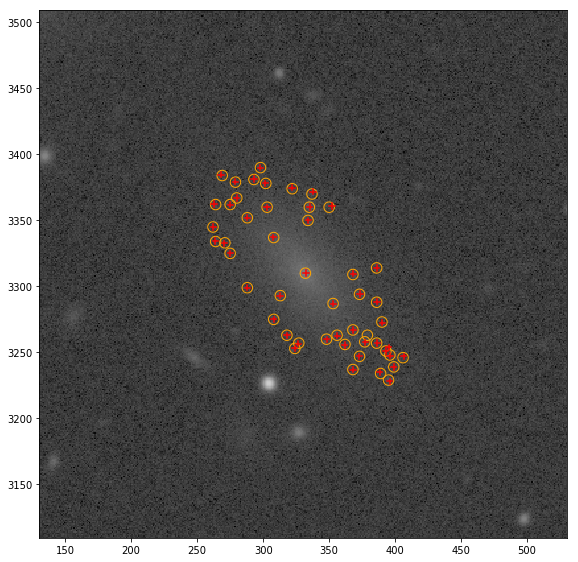

In [34]:
# credit to ADW for this afwDisplay snippet
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[parent_x-200:parent_x+200, parent_y-200:parent_y+200])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

A few comments are in order about the above image.

* We can see the extended elliptical galaxy at the center. Even though you can identify by eye there is just one source here, the deblender shredded this source into 48 children sources. This is a known failure mode of deblenders. Deblending is hard, and we will not attempt to solve it here, instead opting to restrict our attention to footprints. If you are interested in learning more about deblending beyond the scope of footprints, Fred Moolekamp has prepared [deblending notebooks](https://github.com/LSSTScienceCollaborations/StackClub/tree/master/Deblending) for the StackClub.
* The peaks in the parent footprint (red crosses) and  the centers of the deblended children are almost all right about on top of each other. There is, however, a region where there is some miss-match. To see this more clearly, we will re make the plot but zoom in.

<Figure size 576x576 with 0 Axes>

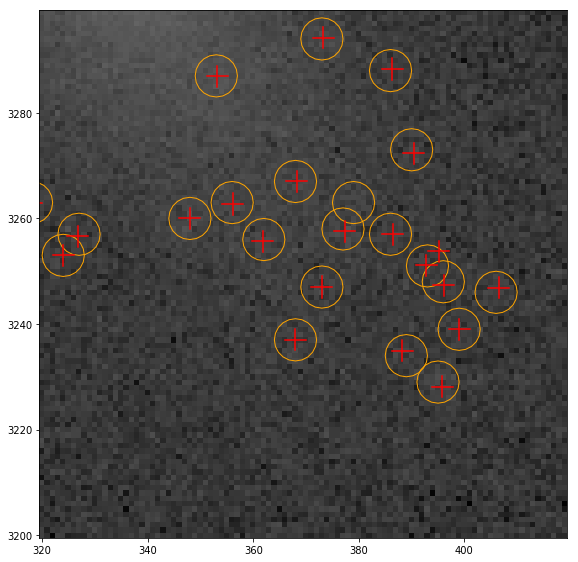

In [35]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[320:420, 3200:3300])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

It is a bit easier to notice that the peaks and child centers are not always conincident in this zoom in. 

We have established that deblending can go wrong, and give us unreliable footprints at times. But how does this impact the measurement process? How much flux actually goes to peaks? We will build our intuition for the impact on deblending in `HeavyFootprints` in the next section.

## Footprints, NoiseReplacer, and Deblending

As we mentioned at the start of our notebook, footprints work hand in hand with detection, deblending, and measurement. In the following few cells we will loosely follow high level steps that are taken in single frame measurement, so we can understand how footprint deblending can impact measurements and science results.

Refering again to Bosch et al 2017, the procedure for source measurement is

1. We replace all Footprints in the image with random Gaussian noise with the same variance as the original noisein those pixels.
2. We insert the deblended pixels for a particular source to be measured back into the image (replacing the noise pixels).
3. We run all measurement plug-ins on the current source.
4. We re-replace the Footprint of the current source with noise.

In our discussion below, we will concentrate on one parent footprint, and visualize its deblended children being swapped back in.

In [36]:
# We will sort the source catalog and grab the object that has the brightest psf flux
cat.sort(cat.getPsfFluxKey())
cat = cat.copy(deep=True)

In [37]:
# Find the centroid of this source so we can visualize it in a few steps
cat[0].getCentroid()

Point2D(2681, 2974)

In [38]:
# Lets grab the parent ID of this source. The deblender can shread sources sometimes
# If we grab the parent, then we can get all its children, this source included
cat[0].getParent()

1010357503384

Before we start playing around with swapping footprints in and out of the frame, lets take a look at the calexp as it is. We can see a nice bright source at the center, along with a few, unassociated, fainter sources in the background

In [39]:
cat.sort()
children = cat.getChildren(1010357503384)['id']

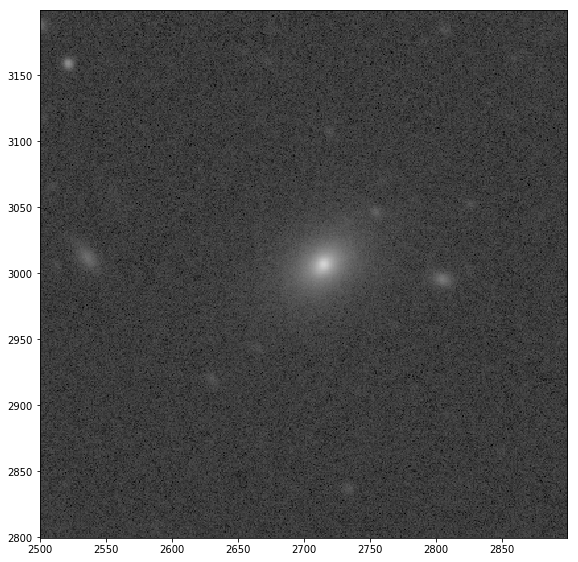

In [40]:
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

Now we will see how we can exchange the detection footprints with noise by using the `NoiseReplacer` object in the stack. We will emulate steps that are taken in SingleFrameMeasurement Task, where measurement algorithms are run on sources. The next two cells are inspired by a few lines from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L305). We will first need to organize our footprints into a dictionary, where the sourceId's are the keys and the associated value pairs are the footprints themselves.

We will also point out here that you can grab footprints right from the source catalog

In [41]:
# prepare footprints in dictionary
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in cat}

In [42]:
# instantiate NoiseReplacer. show it our calexp and footprints
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp, fp_dict)

As we create the `noiseReplacer` object, noise properties are calculated using the pixel values whose associated mask plane pixels have not been set. This noise distribution is used to replace the footprints with generated noise that is supposed to be representative of the true noise properties of the calexp. Now we will display the calexp again to see the result.

<Figure size 576x576 with 0 Axes>

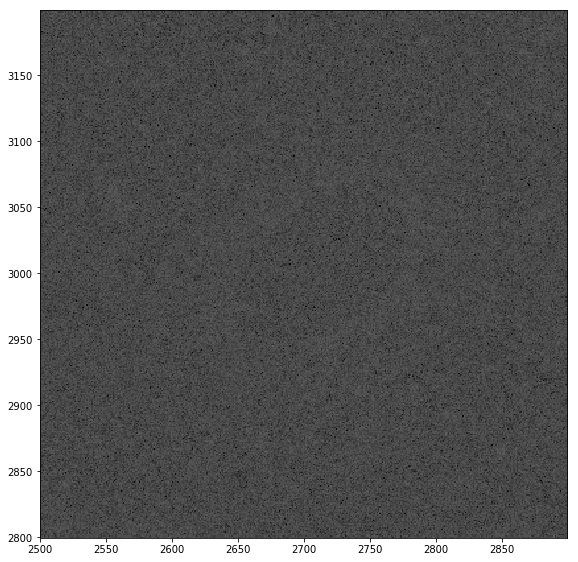

In [43]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

As advertised, we swapped out the data in our footprints with noise. As an aside, if you look closely you can see an 'edge' in the data where the parent object used to be, suggesting perhaps the faint tails of the eliptial's surface brightness profile were missed in detection and now remain in our noise image. 

Now we will draw some more inspiration from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L353) where we will insert our parent footprint of interest back into the image using its ID from the source catalog.

In [44]:
noiseReplacer.insertSource(1010357503384)

<Figure size 576x576 with 0 Axes>

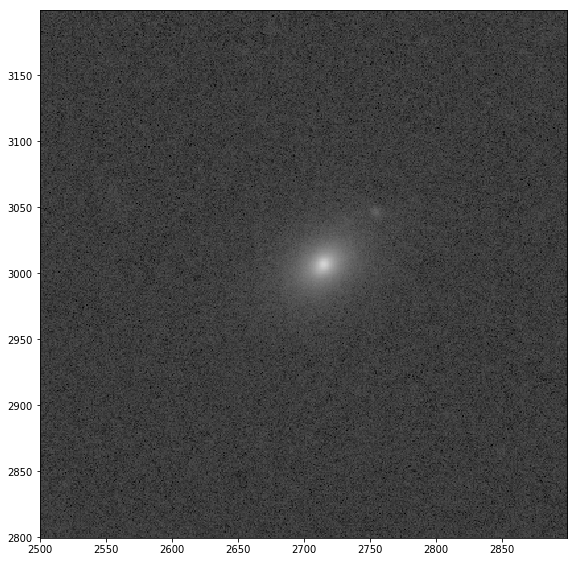

In [45]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

We have used our `NoiseReplacer` instance to ensure this parent footprint is the only source in the image, and all other's have been replaced with noise. Measurement algorithms would be ran on the image in this setting to obtain measurements for this source ID. After that, it will be replaced again with noise, and its deblended children footprints will be exchanged to have their measurements taken in turn. In the next cell we will make a small animation to let us visualize this.

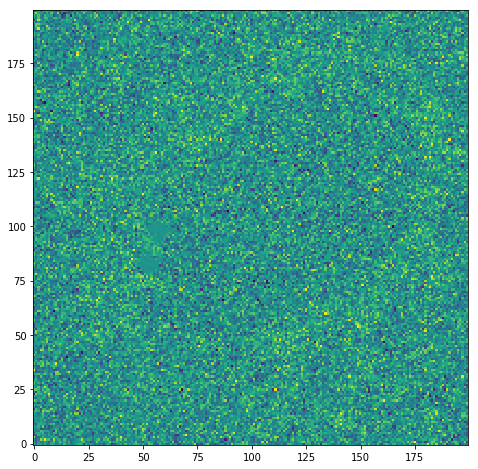

In [46]:
fig = plt.figure()
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

src_ids = [1010357503384] +  children.tolist()

for i in src_ids:
    noiseReplacer.insertSource(i)
    data = calexp.getMaskedImage()[2600:2800,2900:3100].getImage().array
    im = plt.imshow(data, origin='lower', animated=True, vmin=-100, vmax=100)
    ims.append([im])
    noiseReplacer.removeSource(i)

HTML(animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000).to_jshtml())
# takes a minute to get going, 

At first glance, in the animation above it seems the deblending of the big elliptical and fainter smaller source in the upper right are largely successfully deblended. However, there are many other sources that were deblended from the outer wings of the elliptical. Now we will show a few cut outs  of the parent (top left), and first few deblended sources. 

We can see that the eliptical's edges are slightly lacking in flux (top middle) compared to what one may expect from the parent object. In the bottom middle and bottom right pannels, we can see that this flux that ought to have stayed with the elliptical was allocated to some of the peaks around its edges.

Additionally, the fainter companion was well seperated from the eliptical (top right). However, it too was shreded. Looking at the bottom left pannel, we can see some of the flux belonging to the faint companion was siphoned off and allocated to another peak. 

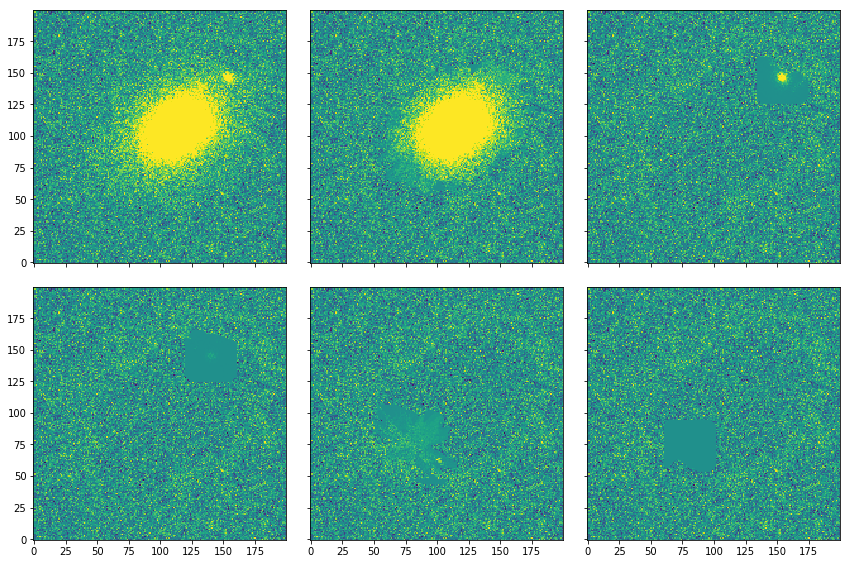

In [47]:
f, ax = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(12,8))

for i, a in zip(range(0, 6), ax.flatten()):
    noiseReplacer.insertSource(src_ids[i])
    data = calexp.getMaskedImage()[2600:2800,2900:3100].getImage().array
    a.imshow(data, origin='lower', animated=True, vmin=-100, vmax=100)
    noiseReplacer.removeSource(src_ids[i])

plt.tight_layout()

It is good pratice to use the end method for the noiseReplacer after you are finished. This will restore our calexp to the state it was in before we began replacing sources with noise, and so forth

In [48]:
noiseReplacer.end()

To drive this point home, we are going to show an image of the parent fooprint, the image of the deblended elliptical galaxy, and the residual of the two. This will allow us to directly visualize the flux that was allocated to the noise peaks around the perimiter of the eliptical.

In [49]:
# Organize our footprints into heavy footprints
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in cat}

heavies = {}
for id, fp in fp_dict.items():
    if fp[1].isHeavy():
        heavies[id] = fp[1]
    elif fp[0] == 0:
        heavies[id] = afwDetection.makeHeavyFootprint(fp[1], calexp.getMaskedImage())

In [50]:
# grab the ID's of the children of the parent footprint
children = cat.getChildren(1010357503384)['id']

# get the image data associated with the first deblended child.
# this is the deblended child footprint for the elliptical
child_data = heavies[children[0]].getImageArray()

# now get the particular indicies of the pixels for this deblended child footprint
idx = heavies[children[0]].getSpans().indices()

# using these indicies, grab the flux from the calexp for these pixels
# child_data and calexp_data are not necessarily equal, because the deblender
# decides how to allocate flux to different children footprints
calexp_data = calexp.getImage().getArray()[idx[0], idx[1]]

# we will also need the child_span, so we can reconstruct images
child_span = heavies[children[0]].getSpans()

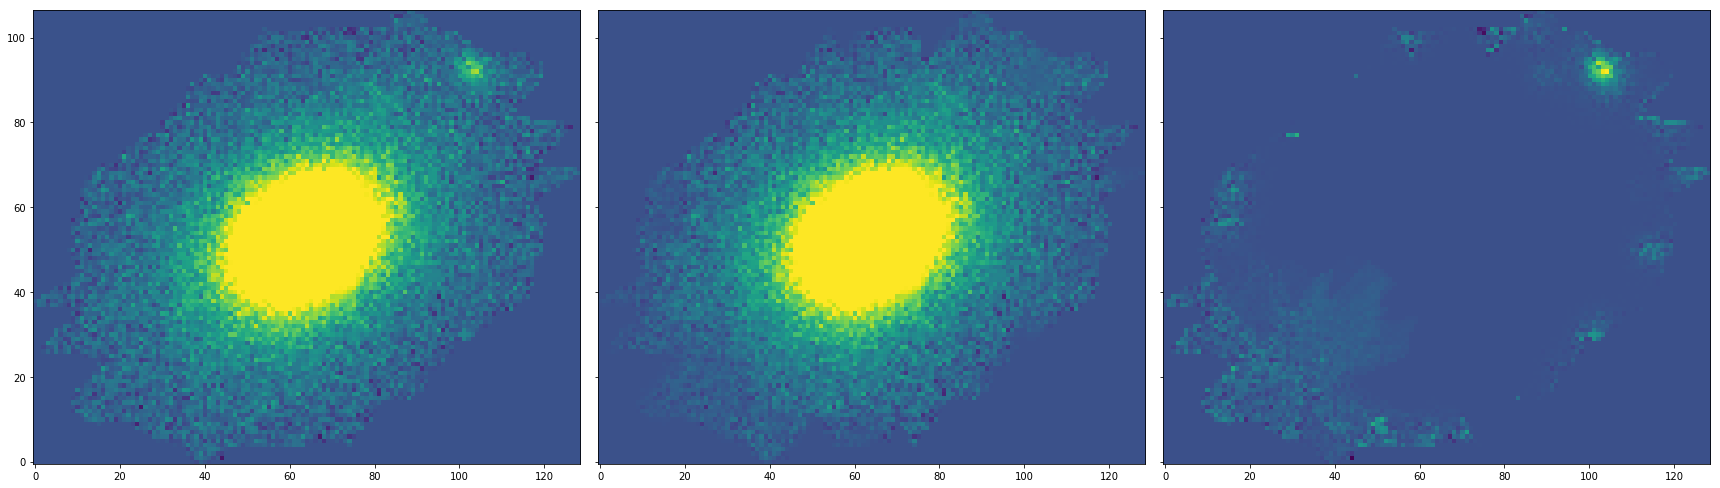

In [51]:
f, ax = plt.subplots(ncols=3, nrows=1, figsize=(24,8), sharey=True)
ax[0].imshow(child_span.unflatten(calexp_data), origin='lower', vmin=-100, vmax=300)
ax[1].imshow(child_span.unflatten(child_data), origin='lower', vmin=-100, vmax=300)
ax[2].imshow(child_span.unflatten(calexp_data) - child_span.unflatten(child_data), origin='lower')
plt.tight_layout()

## Summary

In this notebook, we learned how to make footprints from detection tasks, create heavy footprints, access pixel level data from footprints by making them heavy footprints. We also learned the role footprints play in detection, deblending, and measurement.